# Critical Role Topic Modeling Attempt 2

Last attempt we found ways to improve the model through some google searching. At the end of the last attempt I stated what I wanted to try. I said:
"I would say that there needs to be a lot more cleaning... Topic 0 and 9 are a great example. I also want to encorperate bigram and trigrams into the model."

I also want to add more to this attempt:
- Cleaning
    - Removing Actor/Actresss' Names
    - More rigorous cleaning of stop words
- Encorperate bigram and trigrams in the model
- Try different Coherence Scores

## Import Libraries

In [1]:
!pip install pyLDAvis==3.3.1

     |████████████████████████████████| 1.7 MB 8.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=98ca40396eade307404b93f582de8e267dbe6433313815da12ef9eefdfca832a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
!pip install ipywidgets

In [3]:
!pip install pandarallel==1.4.8

  Created wheel for pandarallel: filename=pandarallel-1.4.8-py3-none-any.whl size=16111 sha256=931b117ae462a6faca1a551a8347fb26bc1f81164a7b714695bb1c18ed320bf2
  Stored in directory: /root/.cache/pip/wheels/c7/f2/4e/e40c8b9344cccf6b8a02d8d8808ba837e72b607c4be946878a
Successfully built pandarallel


In [4]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.6 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=967f4af0e952c406ec3173a91df600633cb083b658fc2c4837d15ef3f9927715
  Stored in directory: /tmp/pip-ephem-wheel-cache-hkox_c9x/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['matt','sam','marisha','laura','travis','talesin','ashley','liam','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading in data, cleaning, tokenizing


### Load

In [2]:
text = open('/content/CR3-16.txt', 'r',encoding = "ISO-8859-1").read()

### Clean

I am probably going to have two cleaning functions. One is going to clean the entire episode. The second will as best as possible only pull lines of the characters and Matt.

Second: Clean the data of the parts of the episode where there is only character and DM's dialog.

In [3]:
def cr_dialog_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is dialog spoken during the episode
    """

    # How to locate where the dialog starts and stops
    ending_intro = "And welcome back."
    starting_break = "And we'll pick up from there after our break."
    starting_outro = "We'll pick up on that next week."
    parts = episode.split(ending_intro)
    first_part = parts[1].split(starting_break)[0]
    second_part = parts[-1].split(starting_outro)[0]
    full_dialog= first_part + "/n" + second_part

    # regex
    remove = string.punctuation
    remove = remove.replace("#", "") # don't remove hyphens
    removing_punctuation = r"[{}]".format(remove)
    non_alpha = '[^a-zA-Z#]'
    spaces = '[^\S ]+'
    multi_white_spaces = "[ ]{2,}"

    full_dialog = re.sub(removing_punctuation, "", full_dialog)
    full_dialog = re.sub(non_alpha, " ", full_dialog)
    full_dialog = re.sub(spaces, '', full_dialog)
    full_dialog = re.sub(multi_white_spaces, " ", full_dialog)
    return pd.DataFrame(full_dialog.lower().split(" # "),columns=['lines'])

In [4]:
full_dialog_df = cr_dialog_cleaner(text)

In [5]:
full_dialog_df.head()

,lines
0,so last we left off hells bells bells hells i...
1,sam yes you should
2,matt the other way around brain thank you
3,liam first was exclamation then you said their...
4,matt indeed i was just excited and then presen...


### Tokenizing data for LDA

In [6]:
# identify how many processors your machine has - save the result to `n_processors`
import multiprocessing

n_processors = multiprocessing.cpu_count()
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

Build the bigram and trigram models

In [8]:
bigram = gensim.models.Phrases(full_dialog_df['lines'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[full_dialog_df['lines']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [10]:
# create our tokens in the form of lemmas 
full_dialog_df['lemmas'] = process_words(full_dialog_df['lines'])

In [11]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(full_dialog_df['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in full_dialog_df['lemmas']]

## LDA Topic Modeling


### Baseline

In [23]:
lda_model_base = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [24]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_base, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5006347768553625


### Attempt 1

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
%%time 
start=2; limit=25;  step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=full_dialog_df['lemmas'], start=start, limit=limit, step=step)

CPU times: user 40.8 s, sys: 7.01 s, total: 47.8 s
Wall time: 46.2 s


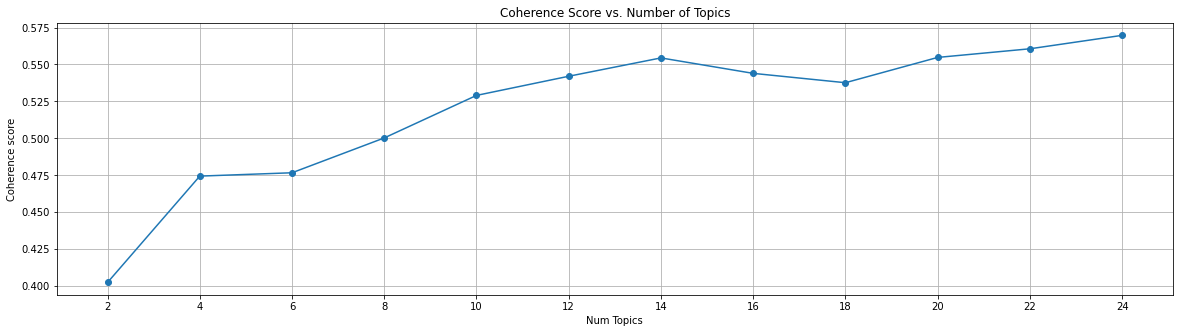

In [27]:
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [28]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_coherence_val_index = np.argmax(coherence_values)
# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_model_1 = model_list[max_coherence_val_index]

In [29]:
coherence_model_lda = CoherenceModel(model=lda_model_1, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5697050543341317


In [40]:
lda_model_1.print_topics()

[(10,
  '0.113*"bit" + 0.072*"creeper" + 0.071*"little" + 0.070*"shade" + 0.059*"begin" + 0.046*"sure" + 0.025*"low" + 0.023*"light" + 0.016*"tunnel" + 0.013*"message"'),
 (12,
  '0.106*"maybe" + 0.045*"stand" + 0.036*"rope" + 0.036*"arm" + 0.034*"around" + 0.031*"step" + 0.031*"movement" + 0.028*"twist" + 0.027*"fail" + 0.022*"almost"'),
 (9,
  '0.064*"side" + 0.055*"mother" + 0.049*"fall" + 0.037*"shade" + 0.036*"begin" + 0.032*"ahead" + 0.025*"large" + 0.025*"chamber" + 0.017*"asleep" + 0.017*"screech"'),
 (4,
  '0.115*"little" + 0.115*"back" + 0.055*"day" + 0.049*"put" + 0.045*"fuck" + 0.035*"bed" + 0.033*"guess" + 0.029*"today" + 0.029*"sound" + 0.022*"hour"'),
 (15,
  '0.060*"cage" + 0.055*"shit" + 0.042*"sometimes" + 0.028*"back" + 0.026*"open" + 0.025*"encounter" + 0.023*"half" + 0.023*"hallway" + 0.022*"morning" + 0.018*"odd"'),
 (0,
  '0.101*"ill" + 0.087*"pull" + 0.081*"rest" + 0.050*"help" + 0.027*"base" + 0.023*"knock" + 0.019*"rock" + 0.018*"watch" + 0.017*"slash" + 0.017

In [41]:
# plot your topics here -- using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_1, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.201263  0.093410       1        1  6.055024
8      0.020190  0.096267       2        1  5.650691
0     -0.089859 -0.133911       3        1  5.255064
11     0.063345 -0.159176       4        1  4.940784
13     0.043093  0.036519       5        1  4.694524
20     0.085250  0.021831       6        1  4.605530
23     0.056092 -0.051701       7        1  4.531702
7      0.047500 -0.044189       8        1  4.489463
17    -0.003066  0.043477       9        1  4.370127
5      0.033210  0.179913      10        1  4.367953
1      0.049642  0.100839      11        1  4.255065
2      0.035022 -0.130667      12        1  4.244750
10    -0.234950  0.077356      13        1  4.135088
19     0.021922 -0.047534      14        1  4.073389
14     0.081034  0.121041      15        1  3.848549
15    -0.054453 -0.125495      16        1  3.815562
3      0.049883 -0.029099      17        1  3.784397
4     -0.209811 -0.069164      18        1  3.782379
6     -0.021084  0.016519      19        1  3.481060
21     0.045428 -0.012928      20        1  3.427393
22     0.055158 -0.009012      21        1  3.223589
12     0.035321  0.015617      22        1  3.179476
16     0.055003  0.012376      23        1  3.168162
18     0.037393 -0.002287      24        1  2.620277, topic_info=          Term       Freq      Total Category  logprob  loglift
307   laughter  98.000000  98.000000  Default  30.0000  30.0000
613       feel  88.000000  88.000000  Default  29.0000  29.0000
569       roll  89.000000  89.000000  Default  28.0000  28.0000
127       look  88.000000  88.000000  Default  27.0000  27.0000
536        hit  80.000000  80.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
1869      sash   1.235270   2.032274  Topic24  -5.4356   3.1440
945       slot   1.145220   1.942224  Topic24  -5.5113   3.1137
1252  instance   0.943075   1.740080  Topic24  -5.7055   3.0294
556       soon   3.085538   7.282344  Topic24  -4.5202   2.7832
233        top   4.616004  21.283583  Topic24  -4.1174   2.1135

[833 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
468      14  0.904846   ability
752       6  0.883384      able
2236     20  0.895481  absolute
2010     10  0.783580   achieve
2170     10  0.621674   acquire
...     ...       ...       ...
400       9  0.894730      wrap
1632     15  0.911714     wrong
732       8  0.876084      yell
1906     13  0.788378    yellow
872      19  0.881786       yet

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 1, 12, 14, 21, 24, 8, 18, 6, 2, 3, 11, 20, 15, 16, 4, 5, 7, 22, 23, 13, 17, 19])

### Attempt 2 
I am not a big fan of 1 and 10 overlapping as much as they do, so did some research into tuning the model better than how it is currently.

In [32]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           workers=2)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [33]:
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics=2
max_topics=11
step_size=1
topics_range=range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01,1,0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01,1,0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=500)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


 10%|█         | 50/500 [03:36<32:28,  4.33s/it]

100%|██████████| 500/500 [27:27<00:00,  3.73s/it]
501it [27:31,  3.60s/it]                         
502it [27:34,  3.63s/it]
503it [27:39,  3.82s/it]
504it [27:43,  3.96s/it]
505it [27:47,  3.85s/it]
506it [27:50,  3.65s/it]
507it [27:53,  3.69s/it]
508it [27:58,  3.81s/it]
509it [28:02,  3.96s/it]
510it [28:05,  3.84s/it]
511it [28:09,  3.68s/it]
512it [28:13,  3.76s/it]
513it [28:17,  3.93s/it]
514it [28:21,  4.10s/it]
515it [28:25,  3.98s/it]
516it [28:29,  3.80s/it]
517it [28:33,  3.88s/it]
518it [28:37,  4.08s/it]
519it [28:42,  4.31s/it]
520it [28:46,  4.12s/it]
521it [28:49,  3.87s/it]
522it [28:53,  3.83s/it]
523it [28:57,  3.89s/it]
524it [29:01,  4.03s/it]
525it [29:05,  3.86s/it]
526it [29:08,  3.74s/it]
527it [29:12,  3.77s/it]
528it [29:16,  3.85s/it]
529it [29:20,  3.96s/it]
530it [29:24,  3.79s/it]
531it [29:27,  3.63s/it]
532it [29:31,  3.73s/it]
533it [29:35,  3.88s/it]
534it [29:39,  4.06s/it]
535it [29:43,  3.94s/it]

In [42]:
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.31)

In [43]:
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5084603994133485


In [36]:
lda_model_2.print_topics()

[(0,
  '0.126*"little" + 0.071*"bit" + 0.060*"stone" + 0.050*"pull" + 0.040*"mind" + 0.037*"night" + 0.035*"hold" + 0.033*"begin" + 0.031*"rock" + 0.024*"chain"'),
 (1,
  '0.127*"feel" + 0.090*"really" + 0.066*"laugh" + 0.059*"people" + 0.052*"maybe" + 0.052*"give" + 0.049*"keep" + 0.040*"hard" + 0.040*"help" + 0.038*"actually"'),
 (2,
  '0.156*"way" + 0.155*"roll" + 0.112*"fall" + 0.052*"ball" + 0.051*"rest" + 0.046*"move" + 0.040*"next" + 0.033*"machine" + 0.021*"pull" + 0.021*"okay"'),
 (3,
  '0.038*"top" + 0.037*"enough" + 0.036*"space" + 0.031*"sit" + 0.028*"begin" + 0.022*"minute" + 0.020*"base" + 0.020*"figure" + 0.019*"green" + 0.017*"dark"'),
 (4,
  '0.069*"check" + 0.064*"great" + 0.058*"leave" + 0.057*"side" + 0.043*"light" + 0.043*"eye" + 0.036*"long" + 0.035*"away" + 0.033*"sort" + 0.032*"fearne"'),
 (5,
  '0.148*"hit" + 0.143*"look" + 0.083*"time" + 0.040*"ahead" + 0.039*"front" + 0.030*"close" + 0.030*"sure" + 0.029*"flame" + 0.026*"watch" + 0.024*"nightmare"'),
 (6,
  '

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.190973  0.034369       1        1  12.465750
4      0.046620 -0.133345       2        1  10.867651
6     -0.065437  0.004973       3        1  10.760489
0      0.219685  0.067254       4        1  10.568247
7     -0.102069 -0.310892       5        1   9.905241
5      0.067843 -0.034730       6        1   9.733620
8     -0.235911  0.119564       7        1   9.129267
2      0.162738  0.160128       8        1   9.084956
1     -0.059787 -0.128617       9        1   8.974500
9     -0.224655  0.221295      10        1   8.510281, topic_info=         Term        Freq       Total Category  logprob  loglift
307  laughter  268.000000  268.000000  Default  30.0000  30.0000
268      back  188.000000  188.000000  Default  29.0000  29.0000
5         way  153.000000  153.000000  Default  28.0000  28.0000
569      roll  152.000000  152.000000  Default  27.0000  27.0000
536       hit  157.000000  157.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
726      butt    3.209459    3.360065  Topic10  -5.6588   2.4180
633    chance    3.118963    3.269569  Topic10  -5.6874   2.4167
217     stand   62.213091   69.071740  Topic10  -2.6943   2.3593
373      head   26.766447   40.940268  Topic10  -3.5377   2.0389
645       ill    4.324161  135.056907  Topic10  -5.3607  -0.9776

[363 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
468       9  0.951180    ability
752       7  1.026367       able
519       9  0.998029   actually
266       8  0.998851  advantage
505       6  0.994823      ahead
...     ...       ...        ...
371       7  0.977547       work
422       4  1.009731      worry
610       5  1.005484      worth
400      10  0.933689       wrap
732      10  0.996083       yell

[366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 1, 8, 6, 9, 3, 2, 10])

### Visualing topics better!

In [38]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=full_dialog_df['lemmas']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_2, corpus=corpus, texts=full_dialog_df['lemmas'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [39]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.602200,"little, bit, stone, pull, mind, night, hold, begin, rock, chain","[look, almost, hourglass, half, thin, pillar, hold, part, together, center, twist, metallic, alm..."
1,1.0,0.439486,"feel, really, laugh, people, maybe, give, keep, hard, help, actually","[usually, careful, far, away, hard, hit, especially, defend, kind, close, moment, mean, give, on..."
2,2.0,0.376630,"way, roll, fall, ball, rest, move, next, machine, pull, okay","[point, move, way, way, back, way, next, part, turn]"
3,3.0,0.697443,"top, enough, space, sit, begin, minute, base, figure, green, dark","[indeed, excite, bell, barely, escape, chaos, top, center, core, return, friend, brother, curren..."
4,4.0,0.474116,"check, great, leave, side, light, eye, long, away, sort, fearne","[creature, humanoid, hunch, table, side, head, straight, whoosh, look, entrance, approach, rest,..."
5,5.0,0.450024,"hit, look, time, ahead, front, close, sure, flame, watch, nightmare","[dozen, opaque, pod, set, slug, mass, watch, mass, taper, side, watch, mass, taper, side, spindl..."
6,6.0,0.459432,"hear, shade, mean, room, creeper, mother, much, start, rush, creature","[separate, lady, thing, mean, potion, eversmoking, bottle, thing, create, giant, smoke, cloud, m..."
7,7.0,0.462575,"back, still, end, turn, foot, attack, finish, push, strike, day","[bring, family, share, mind, blood, climb, bring, together]"
8,8.0,0.381769,"ill, point, guess, thing, well, throw, natural, shit, bad, work","[feel, favorite, lesson, today, sometimes, lesson, learn, sometimes, shit, fucked, thing, fuck, ..."
9,9.0,0.329918,"laughter, wait, stand, hallway, let, pretty, else, happen, head, find","[hallway, stand, wait, door, laughter, hear, absolute, silence, guess, ill, back, bed, laughter]"


# Final Thoughts
I would say that there needs to be a lot more cleaning... Topic 0 and 9 are a great example. I also want to encorperate bigram and trigrams into the model.

Good first go!